# Neural Network Predictions

In this section of the project, the neural networks (For each group of features dataAP, dataPHY and dataALL) defined with the hyperparameters chosen with keras tuner, will be evaluated.

## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

## Loading the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing the dataframes dataAP and dataPHY:

- dataAP: data containing the original variables that best correlate with the label data of the dataframe.

- dataPHY: data containing variables from the blood test that are of interest.

- dataALL: Both dataAP and dataPHY combined

In [3]:
#Importing dataAP
file_name = '/content/drive/MyDrive/TFG/dataAP.csv'
dataAP = pd.read_csv(file_name, index_col=[0])

In [4]:
#Importing dataPHY
file_name = '/content/drive/MyDrive/TFG/dataPHY.csv'
dataPHY = pd.read_csv(file_name, index_col=[0])

In [5]:
#Importing dataALL
file_name = '/content/drive/MyDrive/TFG/dataALL.csv'
dataALL = pd.read_csv(file_name, index_col=[0])

In [6]:
import time

In [7]:
!pip install keras-tuner --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.5 MB/s eta 0:00:00


In [8]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband
import tensorflow as tf
import IPython
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

<ipython-input-8-091a60f0002a>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


One dataframe (**dataAP_g**) will contain the label data in continuous form (Masa_VAT_g) and the other (**dataAP_cat**) will contain the label in
categorical form (Masa_VAT_cat), as stated in the "*Transorming the label data into categotical data*" section from the preprocessing. This is done to avoid confusion when selecting the target variable (Masa_VAT_cat).

Also the label Vol_VAT will be removed as it is technically the same as Masa_VAT.

In [9]:
#Creating a dataAP dataframe only with Masa_VAT_g and another one with only Masa_VAT_cat

dataAP_g = dataAP.copy()
dataAP_cat = dataAP.copy()

dropcat = ["Masa_VAT_g", "Vol_VAT"]
dropg = ["Masa_VAT_cat", "Vol_VAT"]
dataAP_g = dataAP_g.drop(dropg, axis=1)
dataAP_cat = dataAP_cat.drop(dropcat , axis=1)

#And deleting all the label data from dataALL
dropALL = ["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
dataALL = dataALL.drop(dropALL, axis=1)

Defining all the possible datasets:

In [10]:
#DATA AP NN
#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_g"]
X = dataAP_g.drop(target, axis=1).values
y = dataAP_g[target].values	

In [11]:
#DATA PHY NN
#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_g"]
X = dataPHY.values
y = dataAP_g[target].values	

In [12]:
#DATA ALL NN
#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_g"]
X = dataALL.values
y = dataAP_g[target].values	

# Defining the NN with the hyperparameters found with keras tuner: DataAP



Defining the training and testing sets.

In [15]:
#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_g"]
X = dataAP_g.drop(target, axis=1).values
y = dataAP_g[target].values	

In [16]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now we can use X_train and y_train as your training data
# and X_test and y_test as your test data

In [17]:
print(X_train.shape)
print(y_train.shape)

(118, 17)
(118, 1)


Defining the model:

In [18]:

model2= tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(units=160, activation='relu', input_shape= (17,)))
model2.add(tf.keras.layers.Dropout(0))
model2.add(tf.keras.layers.Dense(units=96, activation='relu'))
model2.add(tf.keras.layers.Dropout(0))
model2.add(tf.keras.layers.Dense(1))

model2.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0076208407593745765), metrics= ['mae','mse'])

In [19]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 160)               2880      
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 96)                15456     
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 97        
                                                                 
Total params: 18,433
Trainable params: 18,433
Non-trainable params: 0
_________________________________________________________________


Training the model, using early stopping

In [20]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history= model2.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test, y_test),
    verbose=0, #set verbose=1 for full details at every epoch
    callbacks= [early_stopping_cb])

loss, mae, mse= model2.evaluate(X_test, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) # test mae- 36286

Epoch 60: early stopping
1/1 - 0s - loss: 0.0215 - mae: 0.1201 - mse: 0.0215 - 49ms/epoch - 49ms/step
Test-set Mean absolute error:  0.12


## Visual representation of the predictions vs the actual values of the test set.

1/1 [==============================] - 0s 116ms/step


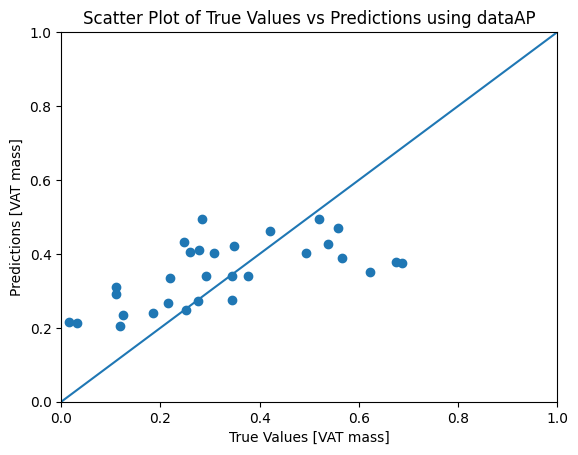

In [22]:
y_pred_test= model2.predict(X_test).flatten()

# a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values [VAT mass]')
plt.ylabel('Predictions [VAT mass]')
plt.title('Scatter Plot of True Values vs Predictions using dataAP')

lims=[0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## K-fold cross-validation to calculate average R2 of the training and testing dataset, as well as the Mean Squared Error or the prediction.

In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Assuming X contains the input features and y contains the corresponding labels

# Initialize performance metrics
train_r2_scores = []
test_r2_scores = []
test_mse_scores = []

# Configure the neural network _> model2

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)  # Number of folds and shuffle option
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the neural network
    model2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Make predictions on the training and test data
    y_pred_train = model2.predict(X_train)
    y_pred_test = model2.predict(X_test)

    # Calculate R2 score for training and test data
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Calculate MSE for test data
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mse_scores.append(test_mse)

# Calculate average scores
average_train_r2 = np.mean(train_r2_scores)
average_test_r2 = np.mean(test_r2_scores)
average_test_mse = np.mean(test_mse_scores)

print("Average Training R2 Score:", average_train_r2)
print("Average Test R2 Score:", average_test_r2)
print("Average Test MSE:", np.sqrt(average_test_mse))


1/1 [==============================] - 0s 31ms/step
Average Training R2 Score: 0.3926277286010391
Average Test R2 Score: 0.3379205191520166
Average Test MSE: 0.13195386188915859


## NN architecture

Installing necessary libraries for the visual representation

In [26]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import graphviz
from keras.utils import plot_model

Plotting the model with keras.utils

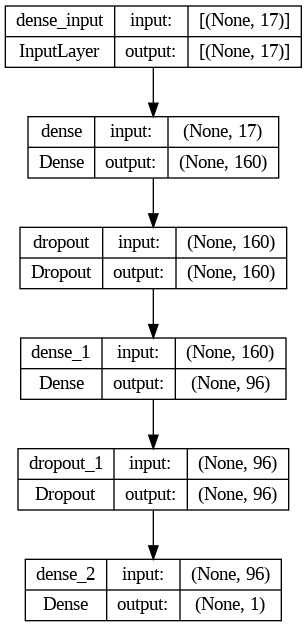

In [29]:
plot_model(model2, to_file='model_architecture.png', show_shapes=True)

Visualizing NN architecture with ann_visualizer

In [30]:
pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=bfe9d64a8fa21efda6dad7eed5b650e3d3d8799c6b11f97105474a7c7c5bbe96
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


In [31]:
from ann_visualizer.visualize import ann_viz
from keras.models import Sequential
from keras.layers import Dense

Saving the visual representation in my personal drive

In [32]:
ann_viz(model2, view=True, filename="/content/drive/MyDrive/TFG/Colab Notebooks/NN architecture with dataAP features as input neurons", title="NN architecture with dataAP features as input neurons")

# Defining the NN with the hyperparameters found with keras tuner: DataPHY



Defining the training and testing sets

In [33]:
#DATA PHY NN
#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_g"]
X = dataPHY.values
y = dataAP_g[target].values	

In [34]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now we can use X_train and y_train as your training data
# and X_test and y_test as your test data

In [35]:
print(X_train.shape)
print(y_train.shape)

(118, 16)
(118, 1)


Defining the model:

In [36]:
model2= tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(units=160, activation='relu', input_shape= (16,)))
model2.add(tf.keras.layers.Dense(units=64, activation='relu'))
model2.add(tf.keras.layers.Dense(1))

model2.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(learning_rate= 0.006528791394798441), metrics= ['mae','mse'])

In [37]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 160)               2720      
                                                                 
 dense_4 (Dense)             (None, 64)                10304     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,089
Trainable params: 13,089
Non-trainable params: 0
_________________________________________________________________


Training the model, using early stopping

In [38]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history= model2.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test, y_test),
    verbose=0, #set verbose=1 for full details at every epoch
    callbacks= [early_stopping_cb])

loss, mae, mse= model2.evaluate(X_test, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) # test mae- 36286

Epoch 61: early stopping
1/1 - 0s - loss: 0.0161 - mae: 0.1108 - mse: 0.0161 - 78ms/epoch - 78ms/step
Test-set Mean absolute error:  0.11


## Visual representation of the predictions vs the actual values of the test set.

1/1 [==============================] - 0s 99ms/step


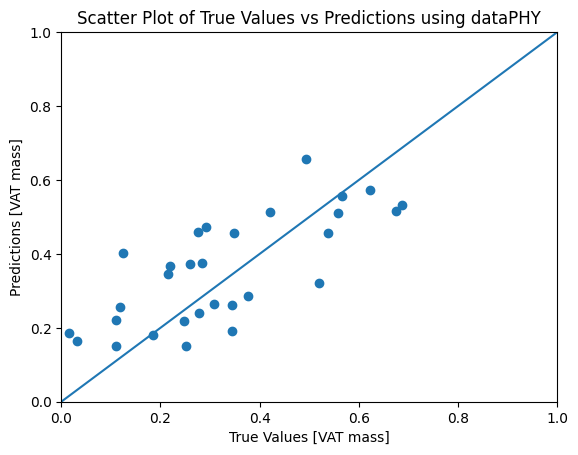

In [40]:
y_pred_test= model2.predict(X_test).flatten()

# a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values [VAT mass]')
plt.ylabel('Predictions [VAT mass]')
plt.title('Scatter Plot of True Values vs Predictions using dataPHY')

lims=[0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## K-fold cross-validation to calculate average R2 of the training and testing dataset, as well as the Mean Squared Error or the prediction.

In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Assuming X contains the input features and y contains the corresponding labels

# Initialize performance metrics
train_r2_scores = []
test_r2_scores = []
test_mse_scores = []

# Configure the neural network _> model2

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)  # Number of folds and shuffle option
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the neural network
    model2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Make predictions on the training and test data
    y_pred_train = model2.predict(X_train)
    y_pred_test = model2.predict(X_test)

    # Calculate R2 score for training and test data
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Calculate MSE for test data
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mse_scores.append(test_mse)

# Calculate average scores
average_train_r2 = np.mean(train_r2_scores)
average_test_r2 = np.mean(test_r2_scores)
average_test_mse = np.mean(test_mse_scores)

print("Average Training R2 using k-cross val:", average_train_r2)
print("Average Test R2 using k-cross val:", average_test_r2)
print("Average Test MSE using k-cross val:", np.sqrt(average_test_mse))


1/1 [==============================] - 0s 129ms/step
Average Training R2 using k-cross val: 0.9192293220392578
Average Test R2 using k-cross val: 0.7903780750334745
Average Test MSE using k-cross val: 0.07294007023731068


## NN architecture

Installing necessary libraries for the visual representation

In [44]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import graphviz
from keras.utils import plot_model

Plotting the model with keras.utils

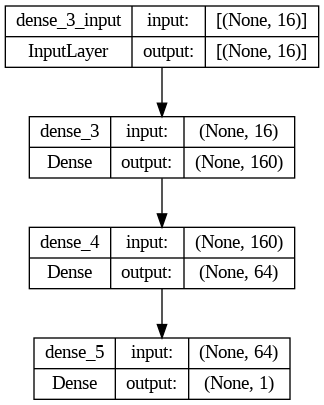

In [47]:
plot_model(model2, to_file='model_architecture.png', show_shapes=True)

Visualizing NN architecture with ann_visualizer

In [48]:
pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from ann_visualizer.visualize import ann_viz
from keras.models import Sequential
from keras.layers import Dense

Saving the visual representation in my personal drive

In [50]:
ann_viz(model2, view=True, filename="/content/drive/MyDrive/TFG/Colab Notebooks/NN architecture with dataPHY features as input neurons", title="NN architecture with dataPHY features as input neurons")

# Defining the NN with the hyperparameters found with keras tuner. dataALL



Defining the testing and training sets:

In [52]:
#DATA ALL NN
#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_g"]
X = dataALL.values
y = dataAP_g[target].values	

In [53]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now we can use X_train and y_train as your training data
# and X_test and y_test as your test data

In [54]:
print(X_train.shape)
print(y_train.shape)

(118, 33)
(118, 1)


Defining the model:

In [55]:
model2= tf.keras.Sequential()
model2.add(tf.keras.layers.Dense(units=128, activation='relu', input_shape= (33,)))
model2.add(tf.keras.layers.Dense(units=128, activation='relu'))
model2.add(tf.keras.layers.Dense(1))

model2.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(learning_rate= 0.004386943776968041), metrics= ['mae','mse'])

In [56]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               4352      
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,993
Trainable params: 20,993
Non-trainable params: 0
_________________________________________________________________


Training the model, using early stopping

In [57]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=False)

history= model2.fit(
    X_train, y_train,
    epochs=200,
    validation_data=(X_test, y_test),
    verbose=0, #set verbose=1 for full details at every epoch
    callbacks= [early_stopping_cb])

loss, mae, mse= model2.evaluate(X_test, y_test, verbose=2)

print("Test-set Mean absolute error: {:5.2f}".format(mae)) # test mae- 36286

Epoch 63: early stopping
1/1 - 0s - loss: 0.0168 - mae: 0.1059 - mse: 0.0168 - 41ms/epoch - 41ms/step
Test-set Mean absolute error:  0.11


## Visual representation of the predictions vs the actual values of the test set.

1/1 [==============================] - 0s 103ms/step


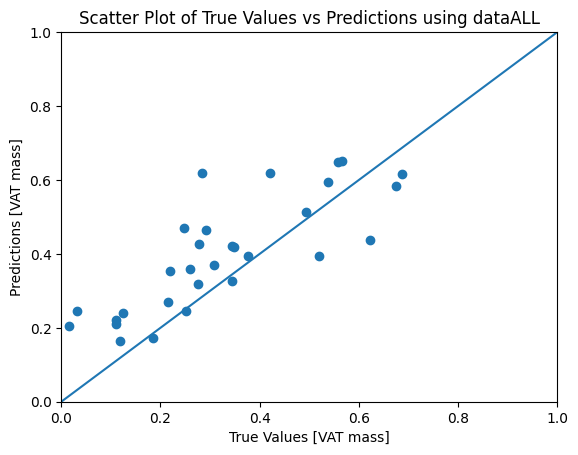

In [59]:
y_pred_test= model2.predict(X_test).flatten()

# a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred_test)
plt.xlabel('True Values [VAT mass]')
plt.ylabel('Predictions [VAT mass]')
plt.title('Scatter Plot of True Values vs Predictions using dataALL')

lims=[0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## K-fold cross-validation to calculate average R2 of the training and testing dataset, as well as the Mean Squared Error or the prediction.

In [62]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

# Assuming X contains the input features and y contains the corresponding labels

# Initialize performance metrics
train_r2_scores = []
test_r2_scores = []
test_mse_scores = []

# Configure the neural network _> model2

# Perform k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True)  # Number of folds and shuffle option
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the neural network
    model2.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # Make predictions on the training and test data
    y_pred_train = model2.predict(X_train)
    y_pred_test = model2.predict(X_test)

    # Calculate R2 score for training and test data
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

    # Calculate MSE for test data
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mse_scores.append(test_mse)

# Calculate average scores
average_train_r2 = np.mean(train_r2_scores)
average_test_r2 = np.mean(test_r2_scores)
average_test_mse = np.mean(test_mse_scores)

print("Average Training R2 Score:", average_train_r2)
print("Average Test R2 Score:", average_test_r2)
print("Average Test MSE:", np.sqrt(average_test_mse))


1/1 [==============================] - 0s 40ms/step
Average Training R2 Score: 0.9175486358699935
Average Test R2 Score: 0.7944862947483108
Average Test MSE: 0.07159238930853135


## NN architecture

Installing necessary libraries for the visual representation

In [63]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import graphviz
from keras.utils import plot_model

Plotting the model with keras.utils

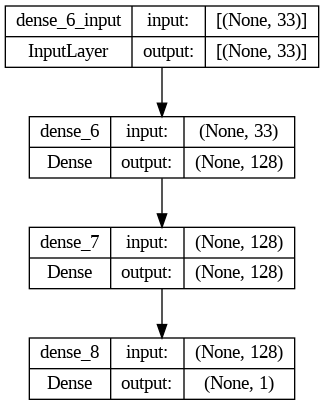

In [66]:
plot_model(model2, to_file='model_architecture.png', show_shapes=True)

Visualizing NN architecture with ann_visualizer

In [67]:
pip install ann_visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
from ann_visualizer.visualize import ann_viz
from keras.models import Sequential
from keras.layers import Dense

Saving the visual representation in my personal drive

In [69]:
ann_viz(model2, view=True, filename="/content/drive/MyDrive/TFG/Colab Notebooks/NN architecture with dataALL features as input neurons", title="NN architecture with dataALL features as input neurons")